In [11]:
import os
import pandas as pd
import numpy as np
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

In [12]:
data_file = 'BTC_15'
number = 1
opti_ratio = 0.75
riskRatio = 1.5
slowLen = 5
fastLen = 18
trend1 = 50
trend2 = 89
trend3 = 144
midLen = 35
lowerLen = 35
c = 45/100

In [13]:
def RandS(data_file,number,opt_ratio):
    data_list=[]
    name=data_file[0:3]
    header = ['Timestamp', 'Open', 'High', 'Low', 'Close']
    for file in os.listdir(data_file):
        if file.endswith('.csv'):
            data_list.append(file)
    for file in data_list:
        if str(number) in file:
            file_string = data_file+'/'+name+str(number)+'.csv'
            df = pd.read_csv(file_string)
            sample_length = len(df)
            in_sample_length = round(sample_length*opt_ratio)
            in_sample = pd.read_csv(file_string,nrows=in_sample_length)
            out_of_sample = pd.read_csv(file_string,names=header,skiprows=in_sample_length)
    return in_sample, out_of_sample

In [19]:
def opt_Analysis(df, riskRatio, slowLen,  fastLen, trend1, trend2, trend3, midLen, lowerLen, c):
    df['a'] = abs(df.apply(lambda row: row.High - row.Low, axis=1))
    df['b'] = abs(df.apply(lambda row: row.Close - row.Open, axis=1))
    df['ca'] = df.apply(lambda row: row.a * c, axis=1)
    df['rv'] = np.where(df['b'].values < df['ca'].values,1,0)
    df['x'] = df.apply(lambda row: row.Low + row.ca, axis=1)
    df['y'] = df.apply(lambda row: row.High - row.ca, axis=1)
    df['sl'] = np.where((df['High'].values>df['y'].values) & (df['Close'].values<df['y'].values) & (df['Open'].values<df['y'].values),1,0)
    df['ss'] = np.where((df['Low'].values<df['x'].values) & (df['Close'].values>df['x'].values) & (df['Open'].values>df['x'].values),1,0)
    df['longlimit'] = np.where((df['sl'] > 0), df['High'].values,np.NaN)
    df['longlimit'] = df['longlimit'].ffill()
    df['longlimit'] = np.array(df['longlimit']).tolist()
    df['shortlimit'] = np.where((df['ss'] > 0), df['Low'].values,np.NaN)
    df['shortlimit'] = df['shortlimit'].ffill()
    df['shortlimit'] = np.array(df['shortlimit']).tolist()
    df['hc'] = df.High - df.Low
    df['hcs'] = abs(df.High-df.Close.shift(1))
    df['lcs'] = abs(df.Low-df.Close.shift(1))
    df['rt'] = df[['hc','hcs','lcs']].max(axis=1)
    df['slow'] = ta.sma(df['Close'],slowLen)
    df['fast'] = ta.ema(df['Close'],fastLen)
    df['trend 1'] = ta.sma(df['Close'],trend1)
    df['trend 2'] = ta.sma(df['Close'],trend2)
    df['trend 3'] = ta.ema(df['Close'],trend3)
    df['mid'] = ta.ema(df['Close'],midLen)
    df['lower'] = ta.ema(df['Close'],lowerLen) + 0.5*(ta.rma(df['rt'],lowerLen))
    df['longOn'] = np.where((df.slow.values>df.fast.values)&(df['trend 1'].values<df.fast.values)&(df['trend 2'].values<df.fast.values)&(df['trend 3'].values<df.fast.values)&(df['mid'].values<df.fast.values)&(df['lower'].values<df.fast.values),'y','n')
    df['shortOn'] = np.where((df.slow.values<df.fast.values)&(df['trend 1'].values>df.fast.values)&(df['trend 2'].values>df.fast.values)&(df['trend 3'].values>df.fast.values)&(df['mid'].values>df.fast.values)&(df['lower'].values>df.fast.values),'y','n')
    df['longstop'] = np.where((df['slow'].values>df['Low'].values),df['fast'].values,df['slow'].values)
    df['shortstop'] = np.where((df['slow'].values<df['High'].values),df['fast'].values,df['slow'].values)
    df['longtarget'] = df.apply(lambda row: abs((row.longstop / row.longlimit) - 1)*riskRatio, axis=1)
    df['longtarget'] = df.apply(lambda row: (row.longlimit * (row.longtarget + 1)), axis=1)
    df['shorttarget'] = df.apply(lambda row: abs((row.shortstop / row.shortlimit) - 1)*riskRatio, axis=1)
    df['shorttarget'] = df.apply(lambda row: (row.shortlimit * (1 - row.shorttarget)), axis=1)
    pd.set_option('display.max_rows', df.shape[0]+1)
    pd.set_option('display.max_columns',df.shape[0]+1)
    return df

In [20]:
in_sample, out_of_sample = RandS('BTC_15',45,0.7)
df = opt_Analysis(out_of_sample, riskRatio, slowLen,  fastLen, trend1, trend2, trend3, midLen, lowerLen, c)

<Figure size 432x288 with 0 Axes>

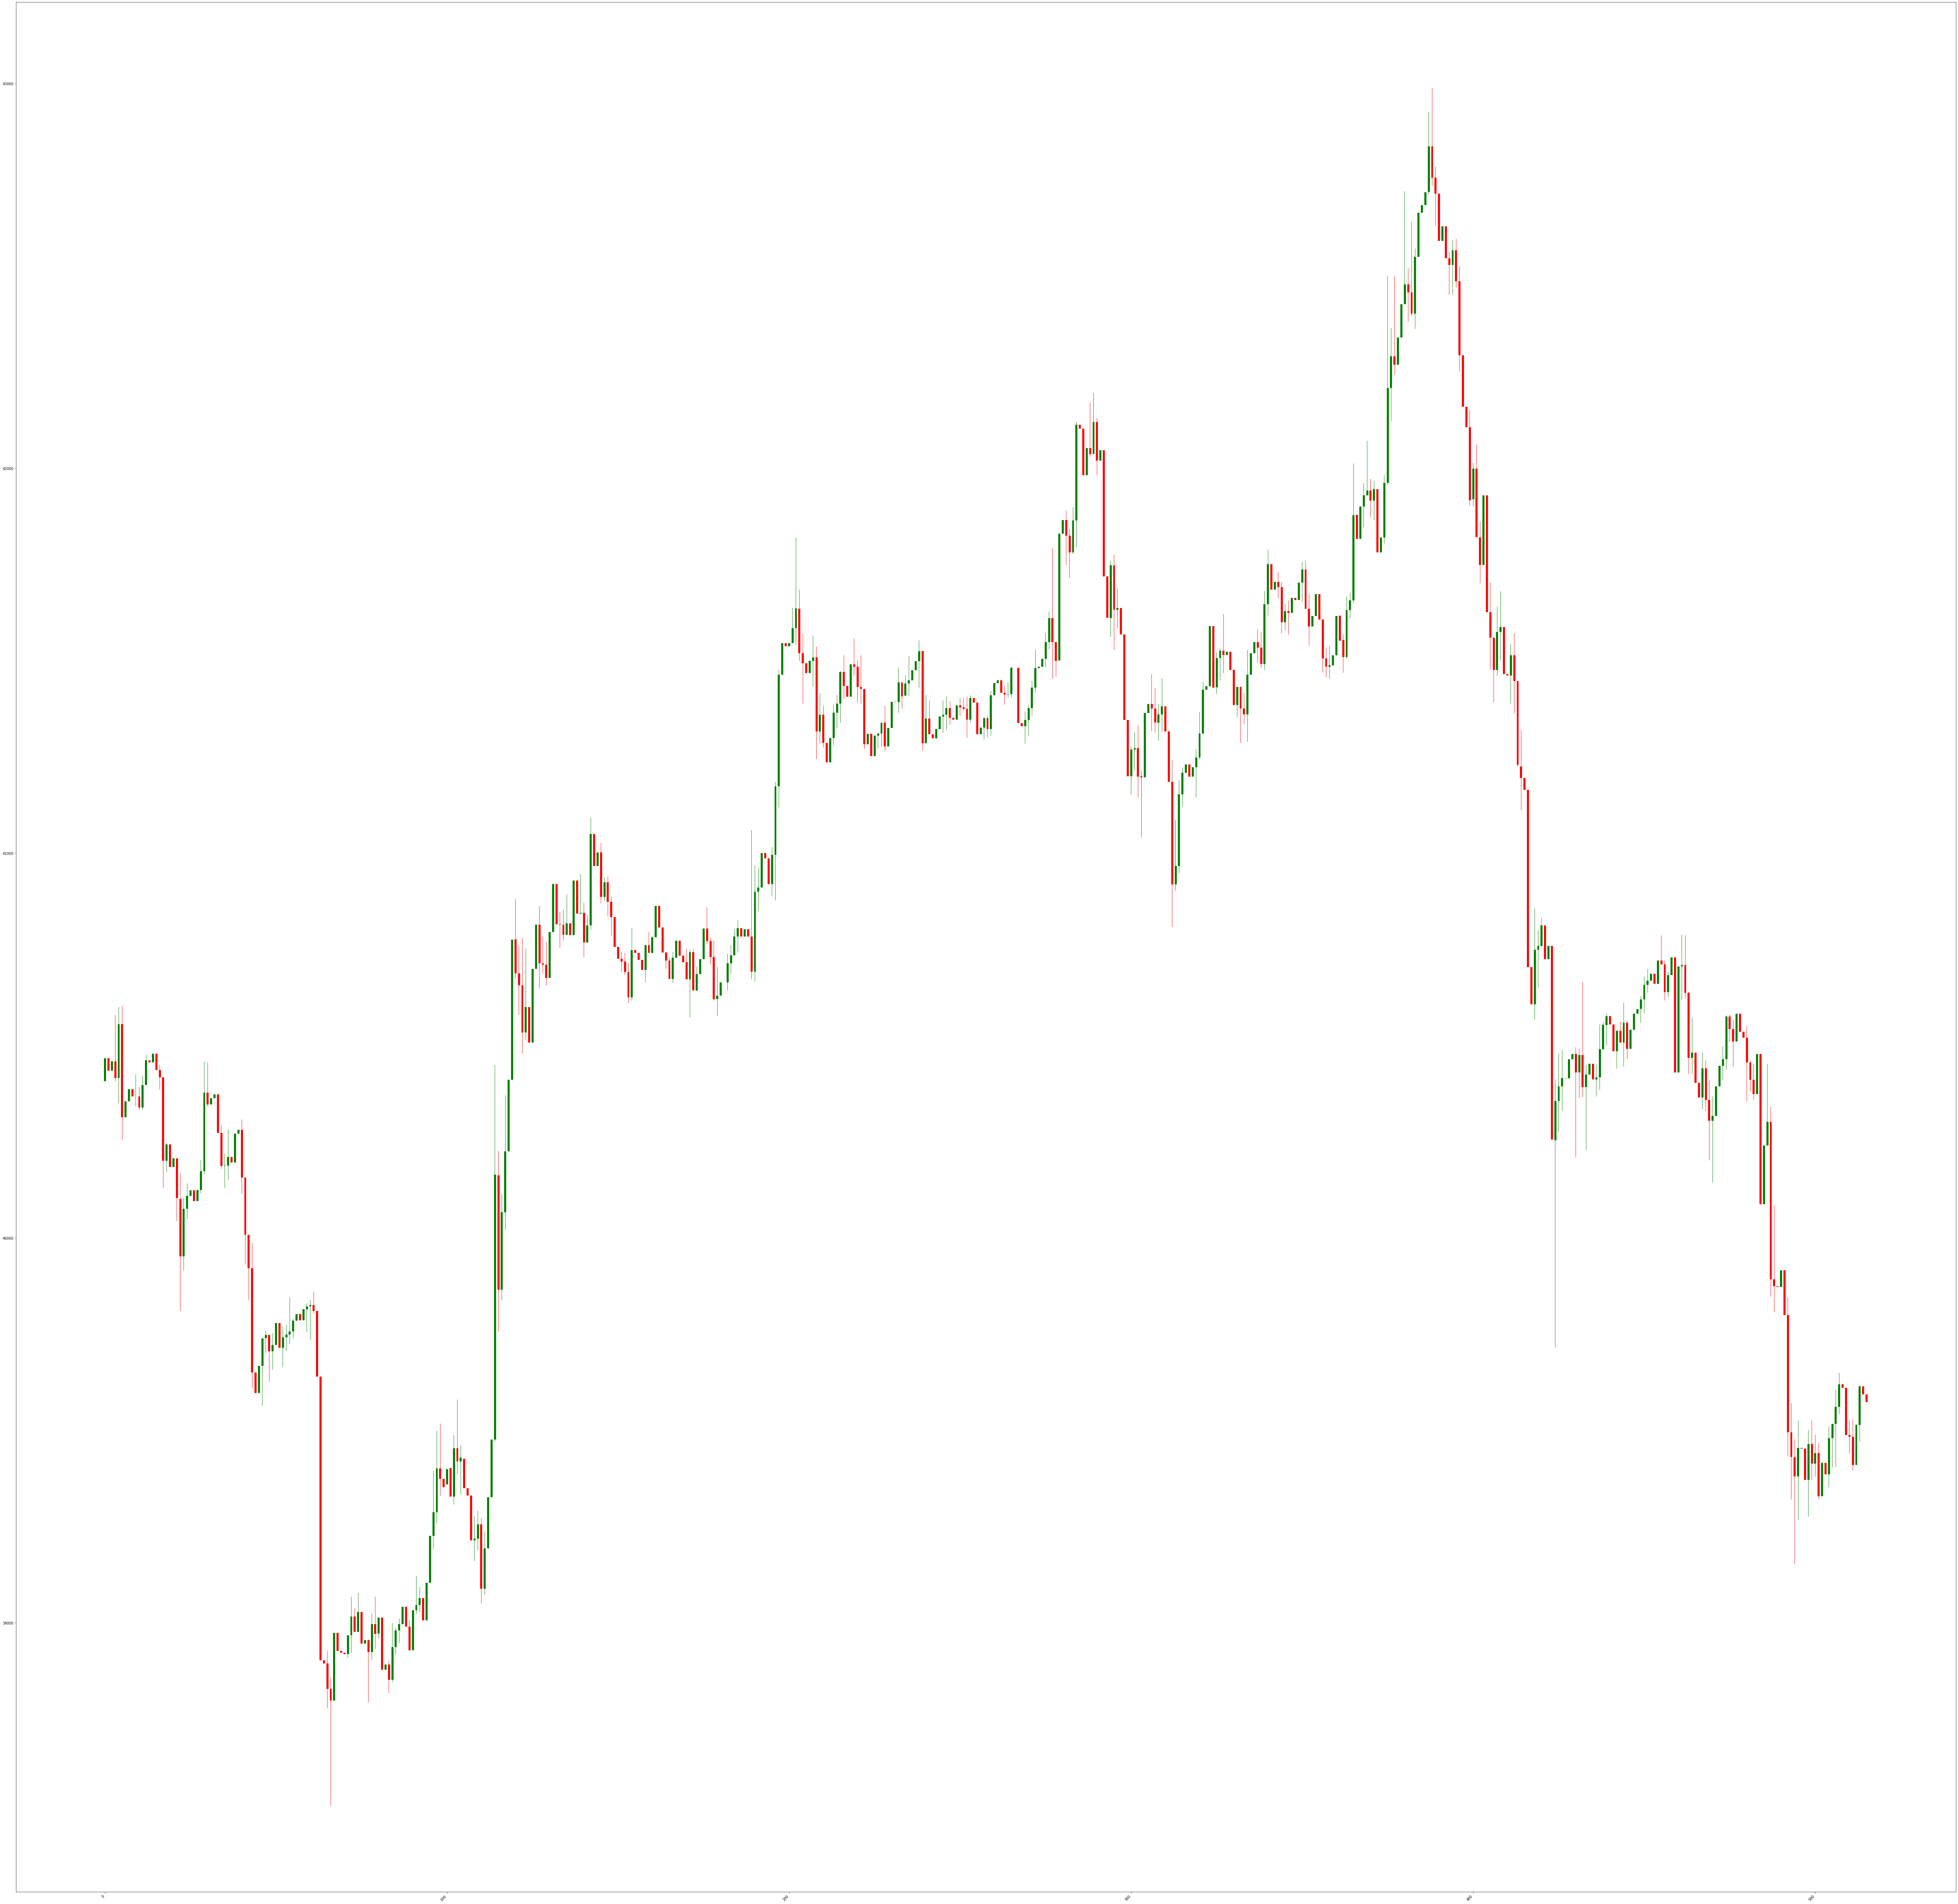

In [18]:
plt.figure()
plt.figure(figsize=(100,100))
#define width of candlestick elements
width = .6
width2 = .06

#define up and down prices
up = df[df.Close>=df.Open]
down = df[df.Close<df.Open]

#define colors to use
col1 = 'green'
col2 = 'red'

#plot up prices
plt.bar(up.index,up.Close-up.Open,width,bottom=up.Open,color=col1)
plt.bar(up.index,up.High-up.Close,width2,bottom=up.Close,color=col1)
plt.bar(up.index,up.Low-up.Open,width2,bottom=up.Open,color=col1)

#plot down prices
plt.bar(down.index,down.Close-down.Open,width,bottom=down.Open,color=col2)
plt.bar(down.index,down.High-down.Open,width2,bottom=down.Open,color=col2)
plt.bar(down.index,down.Low-down.Close,width2,bottom=down.Close,color=col2)

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

# plt.plot(df.slow)
# plt.plot(df.fast)
# plt.plot(df['trend 1'])
# plt.plot(df['trend 2'])
# plt.plot(df['trend 3'])
# plt.plot(df.mid)
# plt.plot(df.lower)
# plt.plot(df.longlimit)
# plt.plot(df.longstop)
# plt.plot(df.longtarget)
# plt.plot(df.shortlimit)
# plt.plot(df.shortstop)
# plt.plot(df.shorttarget)

#display candlestick chart
plt.show()